In [ ]:
!pip install pyspark pandas xgboost scikit-learn matplotlib seaborn Sastrawi nltk streamlit numpy joblib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 85.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 82.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.1 MB/s eta 0:00:00


In [4]:
# Step 1: Setup dan Import Libraries
import pandas as pd
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lower, regexp_replace, split, array_remove
from pyspark.sql.types import StringType, ArrayType
from pyspark.ml.feature import HashingTF, IDF, Tokenizer, StopWordsRemover
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import streamlit as st

# Initialize Spark Session
spark = SparkSession.builder \
    .appName("HoaxDetection") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .getOrCreate()

# Stopwords Bahasa Indonesia
indonesian_stopwords = [
    'yang', 'dan', 'di', 'ke', 'dari', 'dalam', 'untuk', 'pada', 'dengan', 'adalah',
    'ini', 'itu', 'tidak', 'ada', 'akan', 'atau', 'juga', 'telah', 'dapat', 'sudah',
    'bisa', 'harus', 'karena', 'sebagai', 'oleh', 'antara', 'mereka', 'kita', 'kami',
    'saya', 'dia', 'ia', 'beliau', 'anda', 'kamu', 'kalian', 'mereka', 'kami', 'kita'
]

print("✅ Libraries imported dan Spark session initialized")


✅ Libraries imported dan Spark session initialized


In [5]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF
from pyspark.sql.functions import lower, regexp_replace, udf, col
from pyspark.sql.types import ArrayType, StringType
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import pandas as pd

df_pandas = pd.read_csv('news_articles2.csv')


print("Dataset Info:")
print(f"Shape: {df_pandas.shape}")
print(f"Columns: {df_pandas.columns.tolist()}")

# Pilih kolom title dan Label saja, buang kolom lainnya
df_pandas = df_pandas[['title', 'Label']].copy()
df_pandas = df_pandas.rename(columns={'Label': 'label'})

df_pandas['label'] = df_pandas['label'].astype(int)



# Convert ke Spark DataFrame
spark_df = spark.createDataFrame(df_pandas)

# Lowercase dan bersihkan karakter
spark_df = spark_df.withColumn(
    "clean_text",
    lower(regexp_replace(col("title"), "[^a-zA-Z\\s]", ""))
)

# Tokenisasi
tokenizer = Tokenizer(inputCol="clean_text", outputCol="words")

# Stopword removal
stopwords_remover = StopWordsRemover(
    inputCol="words",
    outputCol="filtered_words",
    stopWords=indonesian_stopwords
)

# Stemming pakai UDF
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def stem_tokens(tokens):
    if tokens is not None:
        return [stemmer.stem(token) for token in tokens]
    else:
        return []

stem_udf = udf(stem_tokens, ArrayType(StringType()))

# Setelah stopword removal, buat kolom stemmed
df_filtered = stopwords_remover.transform(tokenizer.transform(spark_df))
df_stemmed = df_filtered.withColumn("stemmed", stem_udf(col("filtered_words")))

# TF-IDF pakai kolom stemmed
hashingTF = HashingTF(inputCol="stemmed", outputCol="rawFeatures", numFeatures=10000)
featurized_data = hashingTF.transform(df_stemmed)

idf = IDF(inputCol="rawFeatures", outputCol="features")
idf_model = idf.fit(featurized_data)
rescaled_data = idf_model.transform(featurized_data)

# Select final columns
final_df = rescaled_data.select("features", "label")

print("✅ Preprocessing selesai")
final_df.show(5)


Dataset Info:
Shape: (20164, 9)
Columns: ['_id', 'query', 'title', 'link', 'time', 'content', 'Label', 'time_info', 'hoax_content']
✅ Preprocessing selesai
+--------------------+-----+
|            features|label|
+--------------------+-----+
|(10000,[1228,1988...|    1|
|(10000,[270,2398,...|    1|
|(10000,[2480,2515...|    1|
|(10000,[434,912,4...|    1|
|(10000,[58,578,11...|    1|
+--------------------+-----+
only showing top 5 rows



In [6]:
# Step 3: Data Splitting dan Konversi ke Pandas

# Split data 80% train, 20% test
train_df, test_df = final_df.randomSplit([0.8, 0.2], seed=42)

print(f"Training data: {train_df.count()} rows")
print(f"Test data: {test_df.count()} rows")

# Convert Spark DataFrame ke Pandas untuk XGBoost
def spark_to_pandas_xy(spark_df):
    """Convert Spark DataFrame dengan features vector ke X, y pandas"""
    rows = spark_df.collect()

    # Extract features dan labels
    X_data = []
    y_data = []

    for row in rows:
        features = row.features.toArray()  # Convert SparseVector ke array
        label = row.label
        X_data.append(features)
        y_data.append(label)

    return np.array(X_data), np.array(y_data)

print("Converting Spark to Pandas...")
X_train, y_train = spark_to_pandas_xy(train_df)
X_test, y_test = spark_to_pandas_xy(test_df)

print("✅ Data splitting dan konversi selesai")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Train labels: {np.bincount(y_train)}")
print(f"Test labels: {np.bincount(y_test)}")

Training data: 16251 rows
Test data: 3913 rows
Converting Spark to Pandas...
✅ Data splitting dan konversi selesai
X_train shape: (16251, 10000)
X_test shape: (3913, 10000)
Train labels: [8104 8147]
Test labels: [1980 1933]


In [7]:
# Step 4: XGBoost Training dan Hyperparameter Tuning

# Hyperparameter tuning dengan GridSearchCV
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.2, 0.3],
    'n_estimators': [100, 200, 300]
}

# Initialize XGBoost classifier
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42
)

# Grid search
print("Starting hyperparameter tuning...")
grid_search = GridSearchCV(
    xgb_model,
    param_grid,
    cv=3,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

# Fit model
grid_search.fit(X_train, y_train)

# Best model
best_model = grid_search.best_estimator_
print(f"✅ Best parameters: {grid_search.best_params_}")
print(f"Best CV score: {grid_search.best_score_:.4f}")

# Predictions
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Evaluasi
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\n📊 Model Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Save model XGBoost saja (pipeline Spark tidak bisa di-pickle)
joblib.dump(best_model, 'hoax_detection_model.pkl')

# Save preprocessing components untuk recreate pipeline nanti
preprocessing_config = {
    'stopwords': indonesian_stopwords,
    'num_features': 10000
}
joblib.dump(preprocessing_config, 'preprocessing_config.pkl')

print("✅ Model dan config saved")



Starting hyperparameter tuning...
Fitting 3 folds for each of 27 candidates, totalling 81 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


✅ Best parameters: {'learning_rate': 0.3, 'max_depth': 7, 'n_estimators': 300}
Best CV score: 0.8743

📊 Model Performance:
Accuracy: 0.9088
Precision: 0.9178
Recall: 0.8955
F1-Score: 0.9065
✅ Model dan config saved


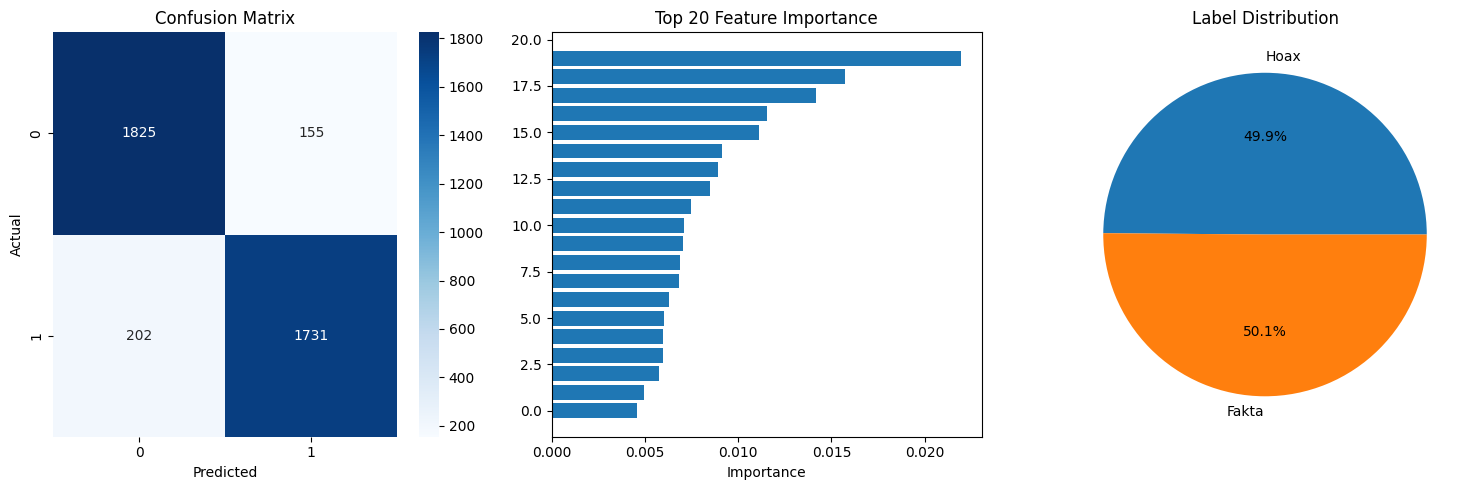

✅ Visualisasi selesai dan disimpan ke 'model_evaluation.png'


In [8]:
# Step 5: Visualisasi Hasil

# 1. Confusion Matrix
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# 2. Feature Importance (Top 20)
plt.subplot(1, 3, 2)
feature_importance = best_model.feature_importances_
top_indices = np.argsort(feature_importance)[-20:]
plt.barh(range(20), feature_importance[top_indices])
plt.title('Top 20 Feature Importance')
plt.xlabel('Importance')

# 3. Label Distribution
plt.subplot(1, 3, 3)
labels = ['Hoax', 'Fakta']
counts = [np.sum(y_train == 0), np.sum(y_train == 1)]
plt.pie(counts, labels=labels, autopct='%1.1f%%')
plt.title('Label Distribution')

plt.tight_layout()
plt.savefig('model_evaluation.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Visualisasi selesai dan disimpan ke 'model_evaluation.png'")